In [1]:
from config import CONFIG, TORCH_GEN
from models.image_text_encoders import FLAIRAdapter
from data import image_UIDs, get_many_answer_gt, SegDataset, CLASS_MAP, NUM_CLASSES, crop_augment_preprocess_batch
from color_map import apply_colormap, COLOR_MAP_DICT

import torch
import torchvision.transforms.v2 as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from functools import partial

# Attention Maps

In [2]:
idxs = list(range(0, 8))

In [3]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
answers_gt_texts = [answers_gt[i]['content'] for i in idxs]
len(answers_gt_texts)

8

In [4]:
img_idxs = image_UIDs[idxs]
viz_ds = SegDataset(img_idxs, resize_size=CONFIG['seg']['image_size'], class_map=CLASS_MAP)
len(viz_ds)

8

In [5]:
n_imgs_per_row = 4

augment_collate_fn = partial(crop_augment_preprocess_batch, crop_fn=T.CenterCrop(CONFIG['seg']['image_size']), augment_fn=None, preprocess_fn=None)
viz_dl = DataLoader(
    viz_ds,
    batch_size=n_imgs_per_row,
    shuffle=False,
    generator=deepcopy(TORCH_GEN),
    collate_fn=augment_collate_fn,
)

In [6]:
model = FLAIRAdapter()

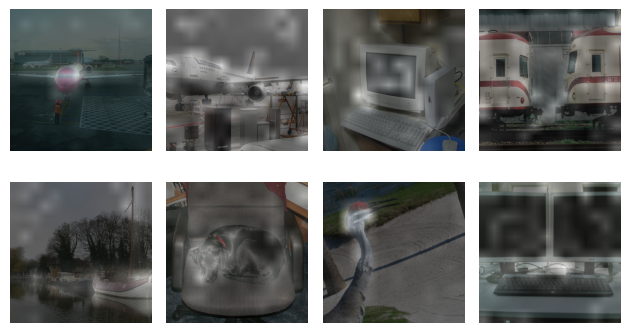

In [7]:
fig, axs = plt.subplots(len(img_idxs)//n_imgs_per_row, n_imgs_per_row)

for row, (scs, gts) in enumerate(viz_dl):
    axs_row = axs[row]
    
    batch_images_tensor = torch.stack([model.preprocess_fn(to_pil_image(sc)) for sc in scs], dim=0).to(CONFIG['device'])
    batch_answers_gt_texts = answers_gt_texts[n_imgs_per_row*row:n_imgs_per_row*(row+1)]
    texts_tensor = model.tokenizer(batch_answers_gt_texts).to(CONFIG['device'])
    
    attn_maps = model.get_attn_maps(batch_images_tensor, texts_tensor, upsample_size=CONFIG['seg']['image_size'], normalize=True)
    
    for col in range(n_imgs_per_row):
        sc_img = to_pil_image(scs[col].cpu())
        attn_map = to_pil_image(attn_maps[col]).convert('RGB')

        ovr_img = Image.blend(sc_img, attn_map, alpha=0.6)
        axs_row[col].imshow(ovr_img)
        axs_row[col].axis('off')
        plt.tight_layout()
plt.show()

# Demo

In [8]:
model = FLAIRAdapter()

(453, 604)


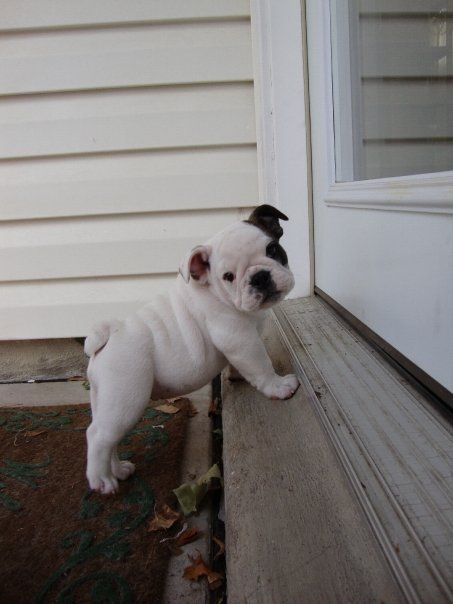

In [9]:
image = Image.open("/home/olivieri/exp/resources/puppy.jpg")
print(image.size)
image

In [10]:
image_tensor = model.preprocess_fn(image).to(CONFIG['device'])
images_tensor = torch.stack([image_tensor]*2, dim=0)
images_tensor.shape

torch.Size([2, 3, 224, 224])

In [11]:
texts_tensor = model.tokenizer([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "The white door and the window on the right side are closed.", # ground-truth caption
    "There are some leaves on the soil.", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
    "Dominating the scene is a white desk, positioned against a white brick wall" # non-ground-truth caption
]).to(CONFIG['device'])

In [12]:
texts_tensor = model.tokenizer([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
]).to(CONFIG['device'])

In [13]:
# with torch.no_grad(), torch.cuda.amp.autocast():
with torch.no_grad(), torch.amp.autocast(CONFIG['device']):
    flair_logits = model.model.get_logits(image=images_tensor, text=texts_tensor)
    clip_logits = model.model.get_logits_as_clip(image=images_tensor, text=texts_tensor)

    print("logits get using flair's way:", flair_logits) # [4.4062,  6.9531, -20.5000, -18.1719]
    print("logits get using clip's way:", clip_logits) # [12.4609, 15.6797, -3.8535, -0.2281]

logits get using flair's way: (tensor([[  4.3906, -20.5000],
        [  4.3906, -20.5000]], device='cuda:0', dtype=torch.float16), tensor([[  4.3906,   4.3906],
        [-20.5000, -20.5000]], device='cuda:0', dtype=torch.float16))
logits get using clip's way: (tensor([[12.4688, -3.8574],
        [12.4688, -3.8574]], device='cuda:0', dtype=torch.float16), tensor([[12.4688, 12.4688],
        [-3.8574, -3.8574]], device='cuda:0', dtype=torch.float16))


In [14]:
attn_maps = model.get_attn_maps(images_tensor, texts_tensor, upsample_size=image.size[::-1], normalize=True, broadcast=False)
attn_maps.shape

torch.Size([2, 1, 604, 453])

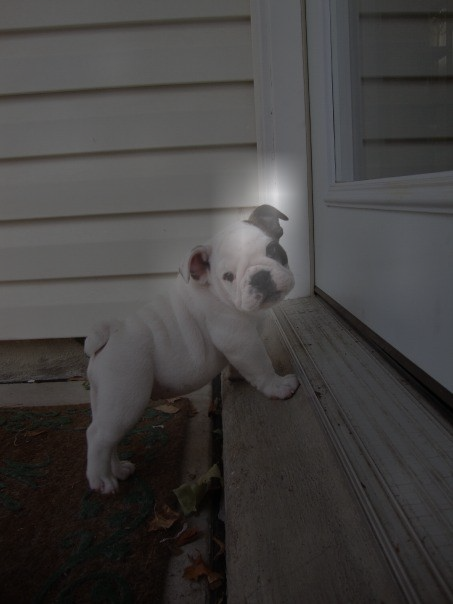

In [15]:
attn_map_img = to_pil_image(attn_maps[0]).convert('RGB')
Image.blend(image, attn_map_img, alpha=0.5)